In [1]:
import import_ipynb
from functionsModel import rank_simple_similarity # Similarities using raw values
from functionsModel import rank_keywords # Similarities using keywords
from functionsModel import rank_embeddings # Similarities using word embeddings
from preprocessText import preprocess_text # Function to process the text

import pandas as pd
import numpy as np

from tabulate import tabulate
import time

import gensim.downloader as api
from pytorch_pretrained_bert import BertTokenizer, BertModel

import matplotlib.pyplot as plt

import os
import pickle

importing Jupyter notebook from functionsModel.ipynb
importing Jupyter notebook from preprocessText.ipynb


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load & Preprocess Tables

## Data lake

In [2]:
# Load data lake
directory = 'Data/Evaluation/Nargesian/DataLake/'
data_lake = []
for filename in os.listdir(directory):
    file = os.path.join(directory, filename)
    table = pd.read_csv(file, encoding = "ISO-8859-1")
    data_lake.append(table)

In [3]:
# Convert data lake tables into text
data_lake_text = [' '.join(table.apply(lambda row: ' '.join(row.astype(str)), axis=1)) for table in data_lake]

In [4]:
# Preprocess text of the tables in the data lake
data_lake_clean = [preprocess_text(table) for table in data_lake_text]

In [5]:
# Save data lake clean to do not have to run the preprocessing every time
with open("Data/Evaluation/Nargesian/datalake_clean", "wb") as fp:   #Pickling
    pickle.dump(data_lake_clean, fp)

In [3]:
# Load already cleaned data lake
with open("Data/Evaluation/Nargesian/datalake_clean", "rb") as fp:   # Unpickling
    data_lake_clean = pickle.load(fp)

In [4]:
# Select query - We select one of the tables in the data lake to be the query table
query_number = 0
query = data_lake.pop(query_number) # Select whole table
query_text_clean = data_lake_clean.pop(query_number) # Select directly preprocess text

In [5]:
# Filter out tables with no text
data_lake_filtered = []
data_lake_indexes_filtered = []
for i,table_text in enumerate(data_lake_clean):
    if table_text != '':
        data_lake_filtered.append(table_text)
        data_lake_indexes_filtered.append(i)

In [6]:
def originalIndexes(filtered_indexes, list_original_indexes):
    # Function to go back to original indexes from the filtered ones
    original_indexes = []
    for index in filtered_indexes:
        original_indexes.append(list_original_indexes[index])
    return original_indexes

In [7]:
def actualIndexes(indexes, query_number):
    # Function to retrieve the actual index after poping out the query table
    actual_indexes = []
    for index in indexes:
        if index >= query_number:
            actual_indexes.append(index+1)
        else:
            actual_indexes.append(index)

    return actual_indexes

# Run models on the input tables

In [8]:
def printResultsNargesianTables(indexes, similarities, keywordExtractionMethod = None, embeddingsMethod = None):
    # Funtion to print the output list of top-k most similar tables in a readible way
    if keywordExtractionMethod is not None:
        print("Keyword extraction method: {}".format(keywordExtractionMethod))
    if embeddingsMethod is not None:
        print("Embeddings method: {}".format(embeddingsMethod))

    print("-----")

    table = pd.DataFrame({'Index': indexes, 'Similarity': similarities}) 
    print(tabulate(table, headers=['Index', 'Similarity']))

## Load required models

In [9]:
# Word2Vec
model_Word2Vec = api.load("word2vec-google-news-300")

# BERT
model_name_Bert = 'bert-base-uncased'
tokenizer_Bert = BertTokenizer.from_pretrained(model_name_Bert)
model_Bert = BertModel.from_pretrained(model_name_Bert)
model_Bert.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (den

## Run models

In [2]:
k = 10 # number of tables we want the model to output

Simple Similarity

In [16]:
start_time = time.time()

rank_simple_indexes, rank_simple_similarities = rank_simple_similarity(query, data_lake, k=len(data_lake))
rank_simple_indexes_real = actualIndexes(rank_simple_indexes, query_number)
# printResultsNargesianTables(rank_simple_indexes_real[:k], rank_simple_similarities[:k])

print("-----")
running_time_simple = time.time() - start_time
print("Running time: %s seconds" % round(running_time_simple,2))

-----
Running time: 5.7 seconds


In [17]:
printResultsNargesianTables(rank_simple_indexes_real[:k], rank_simple_similarities[:k])

-----
      Index    Similarity
--  -------  ------------
 0        1   0.225939
 1       21   0.000459137
 2       12   0.000344828
 3        6   0.000167673
 4       11   0.000148697
 5       16   6.94219e-06
 6       14   6.46331e-06
 7       17   5.56854e-06
 8        4   4.21709e-06
 9        5   4.12633e-06


LDA

In [20]:
start_time = time.time()

keywordExtractionMethod = 'lda'

rank_lda_filtered, rank_lda_similarities, running_time_lda_noprocess = rank_keywords(query_text_clean, data_lake_filtered, keywordExtractionMethod, k = len(data_lake_filtered))
rank_lda_indexes = originalIndexes(rank_lda_filtered, data_lake_indexes_filtered)
rank_lda_indexes_real = actualIndexes(rank_lda_indexes, query_number)
# printResultsNargesianTables(rank_lda_indexes_real[:k], rank_lda_similarities[:k], keywordExtractionMethod)

print("-----")
running_time_lda = time.time() - start_time
print("Running time: %s seconds" % round(running_time_lda,2))
print("Running time (no process): %s seconds" % round(running_time_lda_noprocess,2))

-----
Running time: 6.73 seconds


In [19]:
printResultsNargesianTables(rank_lda_indexes_real[:k], rank_lda_similarities[:k], keywordExtractionMethod)


Keyword extraction method: lda
-----
      Index    Similarity
--  -------  ------------
 0        1     0.603306
 1       12     0.0896701
 2       13     0.0188679
 3       21     0
 4       10     0
 5        2     0
 6        3     0
 7        4     0
 8        5     0
 9        6     0


YAKE

In [16]:
start_time = time.time()

keywordExtractionMethod = 'yake'

rank_yake_filtered, rank_yake_similarities, running_time_yake_noprocess = rank_keywords(query_text_clean, data_lake_filtered, keywordExtractionMethod, k = len(data_lake_filtered))
rank_yake_indexes = originalIndexes(rank_yake_filtered, data_lake_indexes_filtered)
rank_yake_indexes_real = actualIndexes(rank_yake_indexes, query_number)
# printResultsNargesianTables(rank_yake_indexes_real[:k], rank_yake_similarities[:k], keywordExtractionMethod)

print("-----")
running_time_yake = time.time() - start_time
print("Running time: %s seconds" % round(running_time_yake,2))
print("Running time (no process): %s seconds" % round(running_time_yake_noprocess,2))

-----
Running time: 278.95 seconds


In [21]:
printResultsNargesianTables(rank_yake_indexes_real[:k], rank_yake_similarities[:k], keywordExtractionMethod)

Keyword extraction method: yake
-----
      Index    Similarity
--  -------  ------------
 0        1    0.469115
 1       13    0.0455397
 2       12    0.00349227
 3       20    0
 4       19    0
 5        2    0
 6        3    0
 7        4    0
 8        5    0
 9        6    0


LDA + Word2Vec

In [22]:
start_time = time.time()

keywordExtractionMethod = 'lda'
embeddingsMethod = 'word2vec'

rank_lda_word2vec_filtered, rank_lda_word2vec_similarities, running_time_lda_word2vec_noprocess = rank_embeddings(query_text_clean, data_lake_filtered, keywordExtractionMethod, embeddingsMethod, model_Word2Vec, k = len(data_lake_filtered))
rank_lda_word2vec_indexes = originalIndexes(rank_lda_word2vec_filtered, data_lake_indexes_filtered)
rank_lda_word2vec_indexes_real = actualIndexes(rank_lda_word2vec_indexes, query_number)
# printResultsNargesianTables(rank_lda_word2vec_indexes_real[:k], rank_lda_word2vec_similarities[:k], keywordExtractionMethod, embeddingsMethod)

print("-----")
running_time_lda_word2vec = time.time() - start_time
print("Running time: %s seconds" % round(running_time_lda_word2vec,2))
print("Running time (no process): %s seconds" % round(running_time_lda_word2vec_noprocess,2))

-----
Running time: 0.04 seconds


In [23]:
printResultsNargesianTables(rank_lda_word2vec_indexes_real[:k], rank_lda_word2vec_similarities[:k], keywordExtractionMethod, embeddingsMethod)

Keyword extraction method: lda
Embeddings method: word2vec
-----
      Index    Similarity
--  -------  ------------
 0        1   0.00256899
 1       12   0.00227715
 2       21   0.000701844
 3        8   0.000645691
 4       11   0.000604231
 5        7   0.000597967
 6        6   0.000597149
 7        5   0.000597109
 8       13   0.000584226
 9        4   0.000579405


LDA + BERT

In [24]:
start_time = time.time()

keywordExtractionMethod='lda'
embeddingsMethod = 'bert'

rank_lda_bert_filtered, rank_lda_bert_similarities, running_time_lda_bert_noprocess = rank_embeddings(query_text_clean, data_lake_filtered, keywordExtractionMethod, embeddingsMethod, model_Bert, tokenizer_Bert, k = len(data_lake_filtered))
rank_lda_bert_indexes = originalIndexes(rank_lda_bert_filtered, data_lake_indexes_filtered)
rank_lda_bert_indexes_real = actualIndexes(rank_lda_bert_indexes, query_number)
# printResultsNargesianTables(rank_lda_bert_indexes_real[:k], rank_lda_bert_similarities[:k], keywordExtractionMethod, embeddingsMethod)

print("-----")
running_time_lda_bert = time.time() - start_time
print("Running time: %s seconds" % round(running_time_lda_bert,2))
print("Running time (no process): %s seconds" % round(running_time_lda_bert_noprocess,2))

-----
Running time: 0.42 seconds


In [25]:
printResultsNargesianTables(rank_lda_bert_indexes_real[:k], rank_lda_bert_similarities[:k], keywordExtractionMethod, embeddingsMethod)

Keyword extraction method: lda
Embeddings method: bert
-----
      Index    Similarity
--  -------  ------------
 0        1    0.00785884
 1       12    0.00748419
 2       21    0.00734696
 3       11    0.00720014
 4        7    0.00718866
 5        6    0.00718724
 6        5    0.00718716
 7        4    0.0071698
 8       23    0.00714089
 9       10    0.00711125


YAKE + Word2Vec

In [18]:
start_time = time.time()

keywordExtractionMethod = 'yake'
embeddingsMethod = 'word2vec'

rank_yake_word2vec_filtered, rank_yake_word2vec_similarities, running_time_yake_word2vec_noprocess = rank_embeddings(query_text_clean, data_lake_filtered, keywordExtractionMethod, embeddingsMethod, model_Word2Vec, k = len(data_lake_filtered))
rank_yake_word2vec_indexes = originalIndexes(rank_yake_word2vec_filtered, data_lake_indexes_filtered)
rank_yake_word2vec_indexes_real = actualIndexes(rank_yake_word2vec_indexes, query_number)
# printResultsNargesianTables(rank_yake_word2vec_indexes_real[:k], rank_yake_word2vec_similarities[:k], keywordExtractionMethod, embeddingsMethod)

print("-----")
running_time_yake_word2vec = time.time() - start_time
print("Running time: %s seconds" % round(running_time_yake_word2vec,2))
print("Running time (no process): %s seconds" % round(running_time_yake_word2vec_noprocess,2))

-----
Running time: 283.82 seconds


In [27]:
printResultsNargesianTables(rank_yake_word2vec_indexes_real[:k], rank_yake_word2vec_similarities[:k], keywordExtractionMethod, embeddingsMethod)

Keyword extraction method: yake
Embeddings method: word2vec
-----
      Index    Similarity
--  -------  ------------
 0        1   4.55045e-05
 1       13   3.59035e-05
 2       20   2.0679e-05
 3       19   1.02293e-05
 4       23   7.15738e-06
 5       22   5.03005e-06
 6       21   2.65334e-06
 7       12   1.38717e-06
 8        8   5.23958e-07
 9       18   4.48135e-07


YAKE + BERT

In [19]:
start_time = time.time()

keywordExtractionMethod='yake'
embeddingsMethod = 'bert'

rank_yake_bert_filtered, rank_yake_bert_similarities, running_time_yake_bert_noprocess = rank_embeddings(query_text_clean, data_lake_filtered, keywordExtractionMethod, embeddingsMethod, model_Bert, tokenizer_Bert, k = len(data_lake_filtered))
rank_yake_bert_indexes = originalIndexes(rank_yake_bert_filtered, data_lake_indexes_filtered)
rank_yake_bert_indexes_real = actualIndexes(rank_yake_bert_indexes, query_number)
# printResultsNargesianTables(rank_yake_bert_indexes_real[:k], rank_yake_bert_similarities[:k], keywordExtractionMethod, embeddingsMethod)

print("-----")
running_time_yake_bert = time.time() - start_time
print("Running time: %s seconds" % round(running_time_yake_bert,2))
print("Running time (no process): %s seconds" % round(running_time_yake_bert_noprocess,2))

-----
Running time: 277.42 seconds


In [29]:
printResultsNargesianTables(rank_yake_bert_indexes_real[:k], rank_yake_bert_similarities[:k], keywordExtractionMethod, embeddingsMethod)

Keyword extraction method: yake
Embeddings method: bert
-----
      Index    Similarity
--  -------  ------------
 0       19   0.00033067
 1       13   0.000300701
 2       20   0.000238034
 3       23   0.00016186
 4        1   0.000158187
 5       21   0.000101203
 6       22   4.11329e-05
 7       12   6.76959e-06
 8       18   6.14851e-06
 9        8   5.75387e-06


# Analysis of the results

## Print output rankinngs

In [30]:
results_indexes = {
    'Simple': rank_simple_indexes_real[:k],
    'LDA': rank_lda_indexes_real[:k],
    'Yake': rank_yake_indexes_real[:k],
    'LDA + Word2Vec': rank_lda_word2vec_indexes_real[:k],
    'LDA + BERT': rank_lda_bert_indexes_real[:k],
    'Yake + Word2Vec': rank_yake_word2vec_indexes_real[:k],
    'Yake + BERT': rank_yake_bert_indexes_real[:k]
    }
print(tabulate(results_indexes, list(results_indexes.keys())))

  Simple    LDA    Yake    LDA + Word2Vec    LDA + BERT    Yake + Word2Vec    Yake + BERT
--------  -----  ------  ----------------  ------------  -----------------  -------------
       1      1       1                 1             1                  1             19
      21     12      13                12            12                 13             13
      12     13      12                21            21                 20             20
       6     21      20                 8            11                 19             23
      11     10      19                11             7                 23              1
      16      2       2                 7             6                 22             21
      14      3       3                 6             5                 21             22
      17      4       4                 5             4                 12             12
       4      5       5                13            23                  8             18
       5  

## NDCG

In [ ]:
from sklearn.metrics import ndcg_score

labels = pd.read_excel("Data/Evaluation/Nargesian/LabelledSimilarities.xlsx")

true_similarities = labels[labels['Query']==query_number][['Data Lake Table', 'Similarity']]

true_similarities.set_index('Data Lake Table', inplace=True)

true_similarities.drop(query_number, axis= 0, inplace=True) # Since we are using a table from the data lake as a quer table, we have to delete the similarity with itself

In [32]:
def ndcg(true_similarities, rank_model_indexes, rank_model_similarities, k):
    similaties_by_index = sorted(tuple(zip(rank_model_indexes, rank_model_similarities)), key = lambda x: x[0])
    similarities = [x[1] for x in similaties_by_index]
    ndcg = ndcg_score(np.asarray([true_similarities]), np.asarray([similarities]), k=k)
    return ndcg

Simple similarity

In [33]:
ndcg_simple = ndcg(true_similarities['Similarity'], rank_simple_indexes_real, rank_simple_similarities, k)
print("NDCG:", ndcg_simple)

NDCG: 1.0


LDA

In [34]:
ndcg_lda = ndcg(true_similarities['Similarity'], rank_lda_indexes_real, rank_lda_similarities, k)
print("NDCG:", ndcg_lda)

NDCG: 1.0


YAKE

In [35]:
ndcg_yake = ndcg(true_similarities['Similarity'], rank_yake_indexes_real, rank_yake_similarities, k)
print("NDCG:", ndcg_yake)

NDCG: 1.0


LDA + Word2Vec

In [36]:
ndcg_lda_word2vec = ndcg(true_similarities['Similarity'], rank_lda_word2vec_indexes_real, rank_lda_word2vec_similarities, k)
print("NDCG:", ndcg_lda_word2vec)

NDCG: 1.0


LDA + BERT

In [37]:
ndcg_lda_bert = ndcg(true_similarities['Similarity'], rank_lda_bert_indexes_real, rank_lda_bert_similarities, k)
print("NDCG:", ndcg_lda_bert)

NDCG: 1.0


YAKE + Word2Vec

In [38]:
ndcg_yake_word2vec = ndcg(true_similarities['Similarity'], rank_yake_word2vec_indexes_real, rank_yake_word2vec_similarities, k)
print("NDCG:", ndcg_yake_word2vec)

NDCG: 1.0


YAKE + BERT

In [39]:
ndcg_yake_bert = ndcg(true_similarities['Similarity'], rank_yake_bert_indexes_real, rank_yake_bert_similarities, k)
print("NDCG:", ndcg_yake_bert)

NDCG: 0.38685280723454163


Print NCDG scores

In [40]:
ncdg_scores = {
    'Simple': ndcg_simple,
    'LDA': ndcg_lda,
    'Yake': ndcg_yake,
    'LDA + Word2Vec': ndcg_lda_word2vec,
    'LDA + BERT': ndcg_lda_bert,
    'Yake + Word2Vec': ndcg_yake_word2vec,
    'Yake + BERT': ndcg_yake_bert
    }

for model in ncdg_scores:
    print("{}: {}".format(model, ncdg_scores[model]))

Simple: 1.0
LDA: 1.0
Yake: 1.0
LDA + Word2Vec: 1.0
LDA + BERT: 1.0
Yake + Word2Vec: 1.0
Yake + BERT: 0.38685280723454163


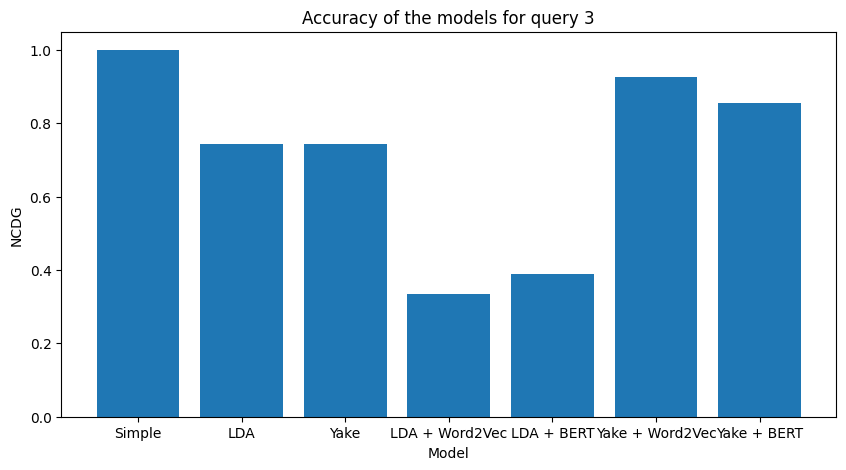

In [17]:
query_number = 3
ncdg_scores = results[query_number]['accuracy']

models = ncdg_scores.keys()
scores = ncdg_scores.values()

fig = plt.figure(figsize = (10, 5))
plt.bar(models, scores)
plt.xlabel("Model")
plt.ylabel("NCDG")
plt.title("Accuracy of the models for query {}".format(query_number))
plt.show()

## Efficiency

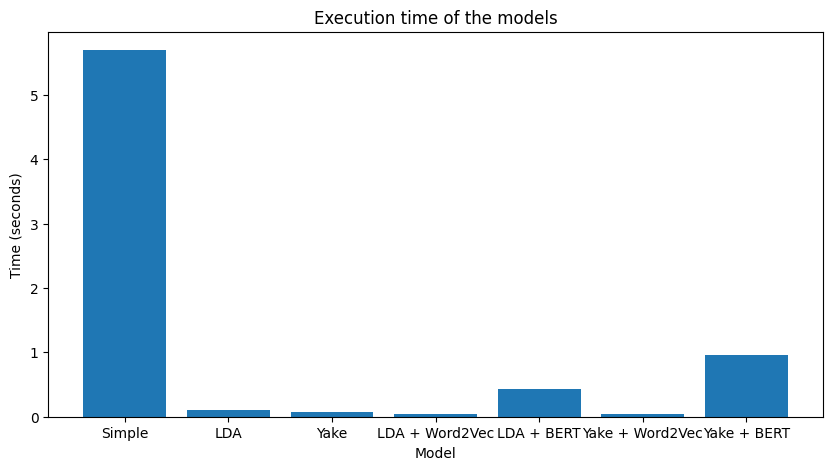

In [42]:
running_times = {
    'Simple': running_time_simple,
    'LDA': running_time_lda,
    'Yake': running_time_yake,
    'LDA + Word2Vec': running_time_lda_word2vec,
    'LDA + BERT': running_time_lda_bert,
    'Yake + Word2Vec': running_time_yake_word2vec,
    'Yake + BERT': running_time_yake_bert
}

models = list(running_times.keys())
times = list(running_times.values())
  
fig = plt.figure(figsize = (10, 5))
plt.bar(models, times)
plt.xlabel("Model")
plt.ylabel("Time (seconds)")
plt.title("Execution time of the models for query {}".format(query_number))
plt.show()

In [ ]:
running_times_noprocess = {
    'Simple': running_time_simple,
    'LDA': running_time_lda_noprocess,
    'Yake': running_time_yake_noprocess,
    'LDA + Word2Vec': running_time_lda_word2vec_noprocess,
    'LDA + BERT': running_time_lda_bert_noprocess,
    'Yake + Word2Vec': running_time_yake_word2vec_noprocess,
    'Yake + BERT': running_time_yake_bert_noprocess
}

models = list(running_times_noprocess.keys())
times = list(running_times_noprocess.values())
  
fig = plt.figure(figsize = (10, 5))
plt.bar(models, times)
plt.xlabel("Model")
plt.ylabel("Time (seconds)")
plt.title("Execution time of the models")
plt.show()

## Overall results

In [43]:
if "results" not in globals():
    results = []
results_query = {
    'query': query_number,
    'accuracy': ncdg_scores,
    'efficiency': running_times,
    'efficiency_noprocess': running_times_noprocess
}

# If there already exists the results for this query, we udpate them. Otherwise, we just append the results for the new query
matching_index = next((i for i, result in enumerate(results) if result['query'] == query_number), None)
if matching_index is not None:
    results[matching_index] = results_query
else:
    results.append(results_query)

In [6]:
accuracies = {}
efficiencies = {}
# efficiencies_noprocess = {}

for result in results:
    for model in result['accuracy']:
        if model not in accuracies:
            accuracies[model] = []
            efficiencies[model] = []
            # efficiencies_noprocess[model] = []
        accuracies[model].append(result['accuracy'][model])
        efficiencies[model].append(result['efficiency'][model])
        # efficiencies_noprocess[model].append(result['efficiency_noprocess'][model])

means_accuracies = {}
means_efficiencies = {}
# means_efficiencies_noprocess = {}

for model, accuracy_list in accuracies.items():
    accuracy_mean = sum(accuracy_list) / len(accuracy_list)
    means_accuracies[model] = accuracy_mean

    efficiency_list = efficiencies[model]
    efficiency_mean = sum(efficiency_list) / len(efficiency_list)
    means_efficiencies[model] = efficiency_mean

    # efficiency_noprocess_list = efficiencies_noprocess[model]
    # efficiency_noprocess_mean = sum(efficiency_noprocess_list) / len(efficiency_noprocess_list)
    # means_efficiencies_noprocess[model] = efficiency_noprocess_mean

print("Mean Accuracies:")
for model, mean in means_accuracies.items():
    print(f"{model}: {mean}")

print("\nMean Efficiencies (Processing data lake):")
for model, mean in means_efficiencies.items():
    print(f"{model}: {mean}")

# print("\nMean Efficiencies (Using a preprocess data lake):")
# for model, mean in means_efficiencies_noprocess.items():
#     print(f"{model}: {mean}")

Mean Accuracies:
Simple: 1.0
LDA: 0.9362428116549264
Yake: 0.9362428116549264
LDA + Word2Vec: 0.8335615511267066
LDA + BERT: 0.6943082143066608
Yake + Word2Vec: 0.5177250796455836
Yake + BERT: 0.33604101968203554

Mean Efficiencies (Processing data lake):
Simple: 26.093993842601776
LDA: 0.13682299852371216
Yake: 3.089224100112915
LDA + Word2Vec: 0.10196161270141602
LDA + BERT: 0.6431064605712891
Yake + Word2Vec: 2.8466858863830566
Yake + BERT: 3.5356555581092834


In [7]:
means_efficiencies_noprocess = means_efficiencies

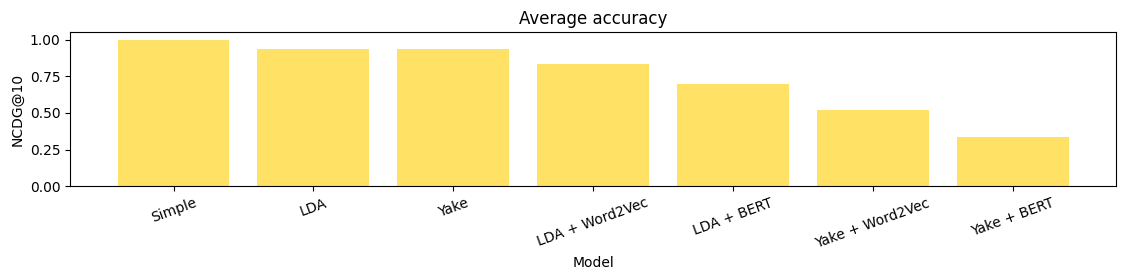

In [8]:
models = means_accuracies.keys()
accuracies = means_accuracies.values()

fig = plt.figure(figsize = (13.5, 2))
plt.bar(models, accuracies, color='#FFE166')
plt.xlabel("Model")
plt.xticks(rotation = 20) # Rotates X-Axis Ticks by 20-degrees
plt.ylabel("NCDG@{}".format(k))
plt.title("Average accuracy")
plt.show()

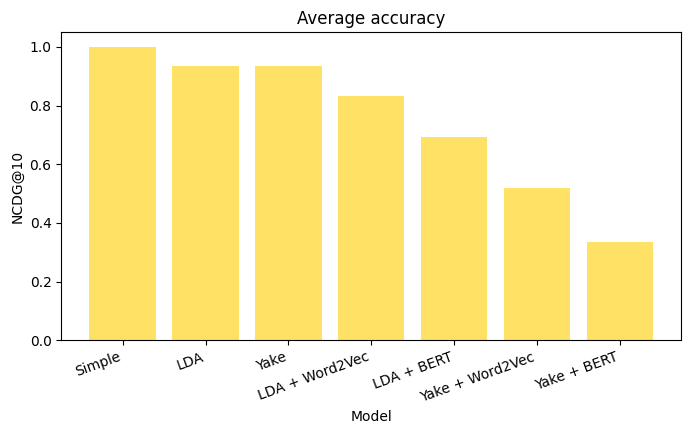

In [8]:
models = means_accuracies.keys()
accuracies = means_accuracies.values()

fig = plt.figure(figsize = (8, 4))
plt.bar(models, accuracies, color='#FFE166')
plt.xlabel("Model")
plt.xticks(rotation = 20, ha='right') # Rotates X-Axis Ticks and alighs the labels
plt.ylabel("NCDG@{}".format(k))
plt.title("Average accuracy")
plt.show()

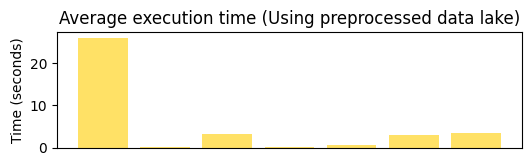

In [105]:
models = means_efficiencies.keys()
efficiencies_noprocess = means_efficiencies.values()

fig = plt.figure(figsize = (6, 1.5))
plt.bar(models, efficiencies_noprocess, color='#FFE166')
plt.xticks([])  # Remove x-axis labels
plt.ylabel("Time (seconds)")
plt.title("Average execution time (Using a preprocessed data lake)")
plt.show()

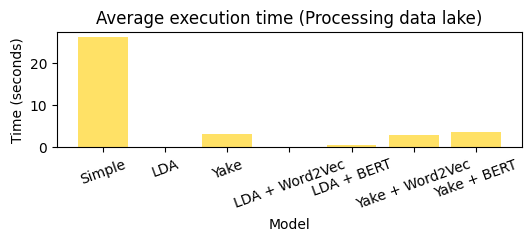

In [93]:
models = means_efficiencies.keys()
efficiencies = means_efficiencies.values()

fig = plt.figure(figsize = (6, 1.5))
plt.bar(models, efficiencies, color='#FFE166')
plt.xlabel("Model")
plt.xticks(rotation = 20) # Rotates X-Axis Ticks by 20-degrees
plt.ylabel("Time (seconds)")
plt.title("Average execution time (Processing the data lake)")
plt.show()

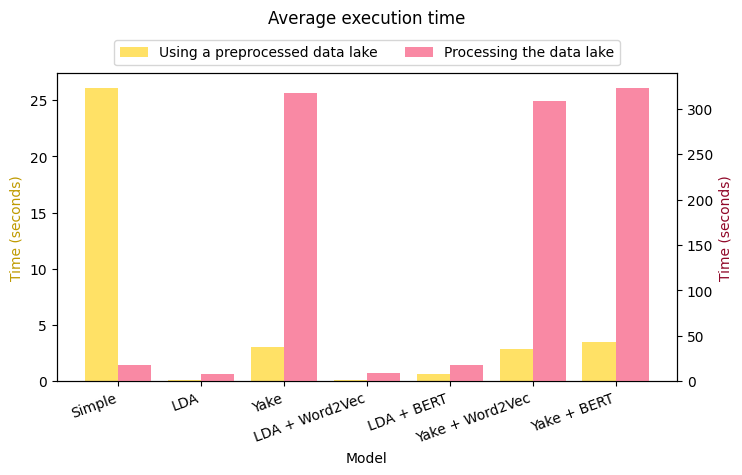

In [51]:
models = means_efficiencies.keys()
efficiencies = means_efficiencies.values()
efficiencies_noprocess = means_efficiencies_noprocess.values()

x = np.arange(len(models))
width = 0.4

fig, ax = plt.subplots(figsize = (8, 4))
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

bar1 = ax.bar(x-(width/2), efficiencies_noprocess, width=width, color='#FFE166')
bar2 = ax2.bar(x+(width/2), efficiencies, width=width, color='#F989A4')
ax.set_xlabel("Model")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation = 20, ha='right') # Rotates X-Axis Ticks by 20-degrees
ax.set_ylabel("Time (seconds)")
ax.yaxis.label.set_color('#BF9A00')
ax2.set_ylabel("Time (seconds)")
ax2.yaxis.label.set_color('#900728')
ax.set_title("Average execution time\n\n")

bars = [bar1, bar2]
labels = ['Using a preprocessed data lake', 'Processing the data lake']
plt.legend(bars, labels, loc='upper center', ncol = 2, bbox_to_anchor=(0.5, 1.13))

plt.show()

# Other Features

In [30]:
with open("Data/Evaluation/Nargesian/results", "wb") as fp:   #Pickling
    pickle.dump(results, fp)

In [5]:
with open("Data/Evaluation/Nargesian/results_noprocess", "rb") as fp:   # Unpickling
    results = pickle.load(fp)

In [24]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 500  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration*2)